In [ ]:
from dataset import get_dataloader
from model import get_mobilenet_v3, freeze_model, unfreeze_model
from utils import add_weight_decay

In [ ]:
import time
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import Dict, List

torch.backends.cudnn.benchmark = True


# Hyper parameters
num_classes = 3
num_epoch = 10
batch_size = 1
lr = 1e-4
weight_decay = 1e-6
warmup_epoch = 3
cache = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model
model = get_mobilenet_v3(num_classes=num_classes)
model = model.to(device)
# Initialize dataloader
train_loader = get_dataloader('train', batch_size, num_classes=num_classes, cache=cache)
val_loader = get_dataloader('val', batch_size, num_classes=num_classes, cache=cache)
# Initialize Optimizer
optimizer = torch.optim.Adam(add_weight_decay(model), lr = lr)
# Loss function
criterion = nn.CrossEntropyLoss(reduction='mean')

# def compute_metrics(gt, predict) -> Dict[str, float]:
#     TP = ((gt == predict) & (gt == 1)).sum()
#     FP = ((gt != predict) & (gt == 1)).sum()
#     TN = ((gt == predict) & (gt == 1)).sum()
#     FN = ((gt == predict) & (gt == 1)).sum()

for epoch in range(num_epoch):
    print(f'epoch = {epoch}')
    start_time = time.time()
    optimizer.zero_grad(set_to_none=True)
    train_losses = 0.0
    train_accs = 0.0
    # Training
    model.training = True

    # Freeze feature layer for warm up
    if epoch < warmup_epoch:
        freeze_model(model)
    else:
        unfreeze_model(model)
    for i, sample in enumerate(tqdm(train_loader)):
        img, label = sample['img'].to(device), sample['label'].to(device)
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        train_losses += loss.item()
        
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        # Calculate accuracy
        label = torch.argmax(label, dim=1).detach().cpu()
        predicted_label = torch.argmax(outputs, dim=1).detach().cpu()
        acc = (label == predicted_label).sum() / len(label)

        train_accs += acc
        del loss
        break
    print('Training Loss : {:.4f}'.format(train_losses / len(train_loader)))
    print('Training Accuracy : {:.4f}'.format(train_accs / len(train_loader)))
    # Validation
    val_losses = 0.0
    val_accs = 0.0
    with torch.no_grad():
        model.eval()
        for sample in tqdm(val_loader):
            img, label = sample['img'].to(device), sample['label'].to(device)
            outputs = model(img)
            loss = criterion(outputs, label)
            val_losses += loss.item()

            # Calculate accuracy
            label = torch.argmax(label, dim=1).detach().cpu()
            predicted_label = torch.argmax(outputs, dim=1).detach().cpu()
            acc = (label == predicted_label).sum() / len(label)
    print('Validating Loss : {:.4f}'.format(val_losses / len(val_loader)))
    print('Validating Accuracy : {:.4f}'.format(val_accs / len(train_loader)))

c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "


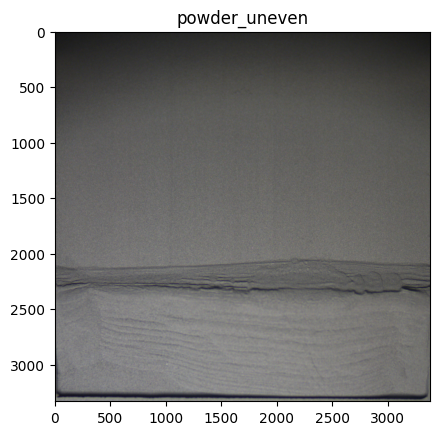

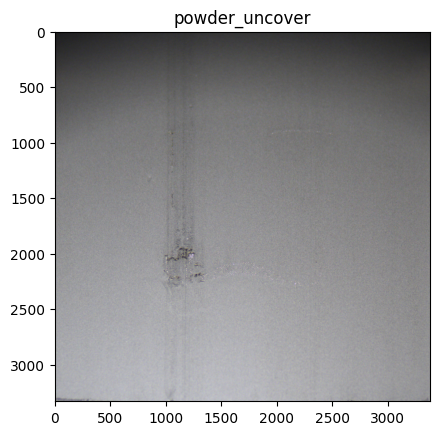

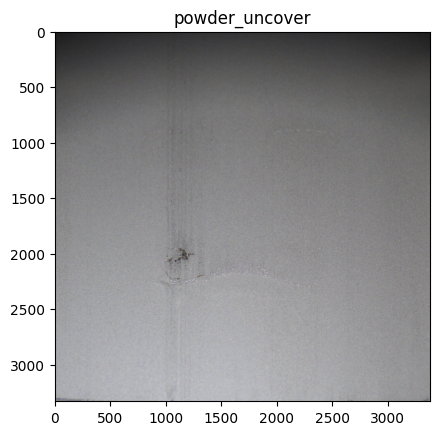

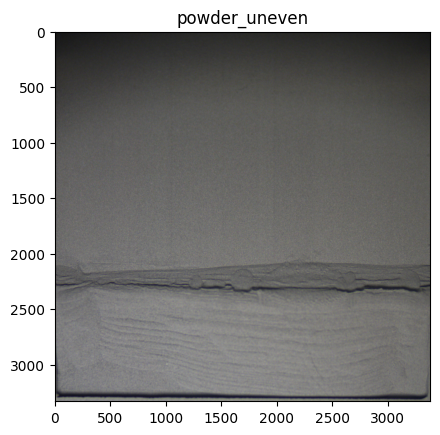

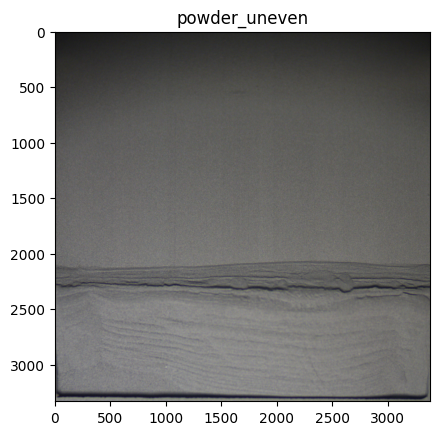

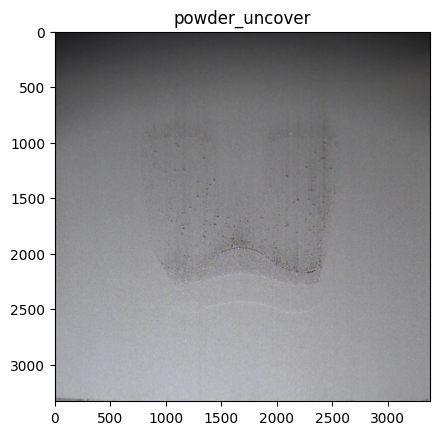

In [1]:
from model import get_mobilenet_v3
from dataset import Transform
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
img_size = (224, 224)
transform = Transform(img_size = img_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = ['powder_uncover', 'powder_uneven', 'scratch']

def predict(img_path: str, model):
    im = Image.open(img_path).convert('RGB')
    im_tensor = transform(im)
    if len(im_tensor.shape) == 3:
        im_tensor = torch.unsqueeze(im_tensor, dim=0)
    with torch.no_grad():
        model.eval()
        model = model.to(device)
        im_tensor = im_tensor.to(device)
        outputs = model(im_tensor)
        label = int(torch.argmax(outputs, dim=1).detach().cpu()[0])
    name = class_names[label]
    plt.title(name)
    plt.imshow(im)
    plt.show()
    im.close()

img_path = '../data/classification/Val/images/'

weight_path = './best.pt'
model = get_mobilenet_v3(3, weight_path=weight_path)
img_names = os.listdir(img_path)
random.shuffle(img_names)
for i, img_name in enumerate(img_names):
    path = os.path.join(img_path, img_name)
    predict(path, model)
    if i == 5:
        break